# Compare
### A notebook for exploring differences between the provided present and future scenario CESM simulations.
##### Initialized by Drew Camron 03/2018
---

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:60312 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


Working directories for `pres_indir` and `fut_indir` datasets featuring *present-time* CESM simulations from Jen Kay **without** land/ocean 2CPC discrimination and `pres_lo_indir` and `fut_lo_indir` for the same **with** these discriminations, along with the CloudSat 2CPC gridded observations and CESM GIS mask file.

In [3]:
pres_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
              'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl/')
fut_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
             'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl/')

pres_lo_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
              'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN/')
fut_lo_indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
            'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl_LANDOCN/')

obs_indir = '/glade/p/work/jenkay/obs/COSP/CLOUDSAT/v2_Tristan/'

mask_indir = '/glade/p/work/lvank/racmo/gismask_RACMO23_0.9x1.25_con.nc'

Here I loop through the observation files to sort by year in `2006-2016` and the months within to read these files in chronologically.

In [4]:
obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [obs_indir+file for file in os.listdir(obs_indir) if mo+yr in file]

Now I open all of these datasets separately and establish usable pandas timedate indices and map the observation data to their lat-lon grids for easier analysis and plotting.

In [5]:
ds_pres = (xr.open_mfdataset(pres_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl.cam.h0.*.nc', decode_times=False)
          ).sel(lat=slice(0, 90))
ds_fut = (xr.open_mfdataset(fut_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl.cam.h0.*.nc', decode_times=False)
         ).sel(lat=slice(0, 90))

ds_lo_pres = (xr.open_mfdataset(pres_lo_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_agl_LANDOCN.cam.h0.*.nc', decode_times=False)
             ).sel(lat=slice(0, 90))
ds_lo_fut = (xr.open_mfdataset(fut_lo_indir+'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_goldenrun_future_agl_LANDOCN.cam.h0.*.nc', decode_times=False)
            ).sel(lat=slice(0, 90))

ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ms = xr.open_dataarray(mask_indir).sel(lat=slice(0, 90))
ms = ms.where(ms > 0)

ds_pres['time'] = pd.date_range('2011-01', '2021-02', freq='MS')
ds_fut['time'] = pd.date_range('2081-01', '2090-12', freq='MS')
ds_lo_pres['time'] = pd.date_range('2011-01', '2025-12', freq='MS')
ds_lo_fut['time'] = pd.date_range('2081-01', '2095-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))

For my own reference, here is a list of the full names of variables in the CloudSat observations.

In [6]:
list(zip([var for var in ds_obs.data_vars],[ds_obs[var].long_name for var in ds_obs.data_vars]))

[('counts', 'Total Observed Pixels'),
 ('asccounts', 'Total Observed Ascending Pixels'),
 ('desccounts', 'Total Observed Descending Pixels'),
 ('noraincounts', 'Total Non-Precipitating Pixels'),
 ('precipcounts', 'Total Precipitating Pixels'),
 ('raincounts', 'Rain Certain Pixels'),
 ('heavyraincounts', 'Heavy (Opaque) Rain Pixels'),
 ('snowcounts', 'Snow Certain Pixels'),
 ('snowpossiblecounts', 'Snow Possible Pixels'),
 ('probablecounts', 'Rain Probable Pixels'),
 ('possiblecounts', 'Rain Possible Pixels'),
 ('mixedcounts', 'Mixed Precipitation Certain Pixels'),
 ('mixedpossiblecounts', 'Mixed Precipitation Possible Pixels'),
 ('convectivecounts', 'Total Convective Rain Pixels'),
 ('stratiformcounts', 'Total Stratiform Rain Pixels'),
 ('shallowcounts', 'Total Warm Rain Pixels'),
 ('ascnoraincounts', 'Ascending Non-Precipitating Pixels'),
 ('ascprecipcounts', 'Ascending Precipitating Pixels'),
 ('ascraincounts', 'Ascending Rain Certain Pixels'),
 ('ascheavyraincounts', 'Ascending Heav

Now I will begin the task of putting together my analysis of, first up, the `LANDOCN` data of Jen's featuring the land-ocean discriminations of 2CPC in her simulations.

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50187 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50188 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50189 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50190 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50191 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50192 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50193 remote=tcp://127.0.0.1:60312>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50194 remote=tcp://127.0.0.1:60312>
distributed.comm

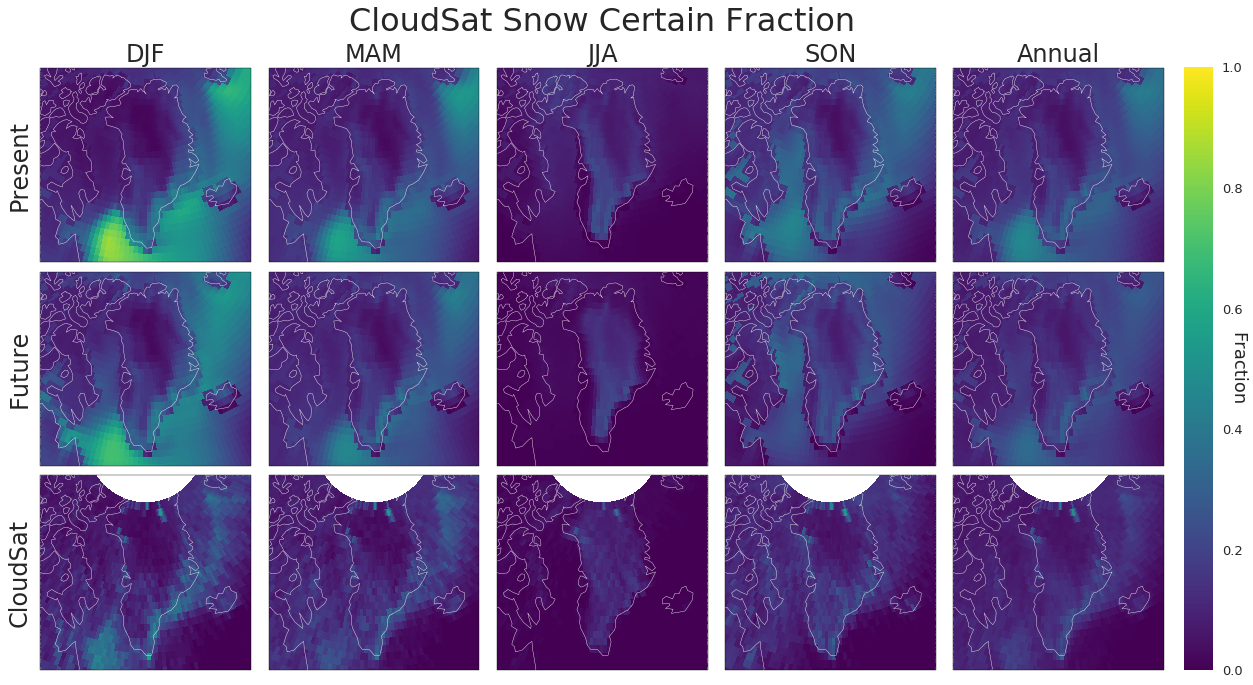

In [7]:
f, axes = plt.subplots(
    nrows=3, ncols=5, figsize=(16, 9),
    subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
)

var='RADAR_SNOWCERT'

for i, x in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    (ds_lo_pres[var]
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[0, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         vmax=100
     )
    )
    
    (ds_lo_fut[var]
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[1, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         vmax=100
     )
    )
    
    ((ds_obs['snowcounts'] / ds_obs['counts'])
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.pcolormesh(
         ax=axes[2, i], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         vmax=1
     )
    )
    
    axes[0, i].set_title(x, fontsize=24)
    
(ds_lo_pres[var]
 .mean('time')
 .plot.pcolormesh(
     ax=axes[0, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=100
 )
)

(ds_lo_fut[var]
 .mean('time')
 .plot.pcolormesh(
     ax=axes[1, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=100
 )
)

p = ((ds_obs['snowcounts'] / ds_obs['counts'])
     .mean('time')
     .plot.pcolormesh(
         ax=axes[2, 4], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, vmax=1
     )
    )

axes[0, 4].set_title('Annual', fontsize=24)
    
for ax in axes.flat:
    ax.coastlines(color='white')
    ax.set_extent([290, 340, 55, 85])


for ax, ylab in zip(axes[:, 0], ['Present', 'Future', 'CloudSat']):
    ax.text(-0.1, 0.5, ylab, rotation='vertical', fontsize=24,
            ha='center', va='center', transform=ax.transAxes)

f.suptitle(ds_lo_pres[var].long_name, y=1.04, fontsize=32)    

plt.tight_layout()

#f.subplots_adjust(right=0.8, hspace=0.0000005, wspace=0.1)
cb_ax = f.add_axes([1.005, 0.017, 0.025, 0.93])
cb = f.colorbar(p, cax=cb_ax)
cb.set_label('Fraction', rotation=270, fontsize=18)

f.savefig('../figures/compare/map_grid_LO.png')